In [1]:
import os
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam # this for python 3.10
import math, time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import shap

Using TensorFlow backend.
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
e:\anaconda\envs\shapenv\lib\site-packages\tensorflow\python\framework\dtypes.py

If running shap change version variable to 3.7, if not set to anthing else.

In [2]:
from sys import version
versioncheck = version[:3] == '3.7'
versioncheck

True

In [3]:
if versioncheck:
    from keras.optimizers import Adam
else:
    pass

In [4]:
os.chdir('../..')

In [5]:
dataset = pd.read_csv('data/data_returns_clean.csv', sep=';',  index_col='date',  parse_dates=['date'])

In [6]:
pd.DataFrame(dataset['Gold'])

,Gold
date,
1986-01-02,NaN
1986-01-03,0.001379
1986-01-06,0.003826
1986-01-07,0.006098
1986-01-08,0.007879
...,...
2022-12-30,0.000000
2023-01-03,0.016265
2023-01-04,0.007622


In [7]:
df = pd.DataFrame(dataset['Gold'].copy())

df['Gold'] = df.Gold.rolling(20).std()
df = df.dropna()

lagging gold col

In [8]:
df['GoldLag']  = df['Gold'].shift(20)
df = df.dropna()

In [9]:
df

,Gold,GoldLag
date,,
1986-02-28,0.014826,0.015446
1986-03-03,0.014251,0.016476
1986-03-04,0.014225,0.016721
1986-03-05,0.013410,0.017831
1986-03-06,0.013491,0.017800
...,...,...
2022-12-30,0.010135,0.009780
2023-01-03,0.008733,0.011269
2023-01-04,0.008419,0.011088


---
# RNN univariate

In [10]:
X_train, y_train = df['GoldLag'].iloc[:-20].values, df['Gold'].iloc[:-20].values
X_test, y_test = df['GoldLag'].iloc[-20:].values, df['Gold'].iloc[-20:].values

In [11]:
scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_trains = scx.fit_transform(X_train.reshape(-1,1))
y_trains = scy.fit_transform(y_train.reshape(-1,1))

In [12]:
adam = Adam(lr=0.001)

In [13]:
# this is needed for python 3.7 , for keras and tf in python 3.10 comment out this cell
if versioncheck:
    from numpy import newaxis

    X_trains =X_trains[:,:,newaxis]
    y_trains.reshape(1,-1)
else:
    pass

In [14]:
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(X_trains.shape[1],1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))

model.compile(loss='mse', optimizer=adam)

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 50)             2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1, 100)            15100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 200)               60200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1) 

In [15]:
history = model.fit(X_trains, y_trains, batch_size=64, epochs=100, verbose=2, use_multiprocessing=True)


Epoch 1/100
 - 1s - loss: 0.0136
Epoch 2/100
 - 0s - loss: 0.0125
Epoch 3/100
 - 0s - loss: 0.0126
Epoch 4/100
 - 0s - loss: 0.0124
Epoch 5/100
 - 0s - loss: 0.0124
Epoch 6/100
 - 0s - loss: 0.0123
Epoch 7/100
 - 0s - loss: 0.0122
Epoch 8/100
 - 0s - loss: 0.0123
Epoch 9/100
 - 0s - loss: 0.0123
Epoch 10/100
 - 0s - loss: 0.0122
Epoch 11/100
 - 0s - loss: 0.0121
Epoch 12/100
 - 0s - loss: 0.0121
Epoch 13/100
 - 0s - loss: 0.0123
Epoch 14/100
 - 0s - loss: 0.0121
Epoch 15/100
 - 0s - loss: 0.0122
Epoch 16/100
 - 0s - loss: 0.0125
Epoch 17/100
 - 0s - loss: 0.0121
Epoch 18/100
 - 0s - loss: 0.0120
Epoch 19/100
 - 1s - loss: 0.0126
Epoch 20/100
 - 0s - loss: 0.0121
Epoch 21/100
 - 0s - loss: 0.0124
Epoch 22/100
 - 0s - loss: 0.0121
Epoch 23/100
 - 0s - loss: 0.0121
Epoch 24/100
 - 0s - loss: 0.0121
Epoch 25/100
 - 0s - loss: 0.0125
Epoch 26/100
 - 0s - loss: 0.0120
Epoch 27/100
 - 0s - loss: 0.0121
Epoch 28/100
 - 0s - loss: 0.0121
Epoch 29/100
 - 0s - loss: 0.0119
Epoch 30/100
 - 0s - l

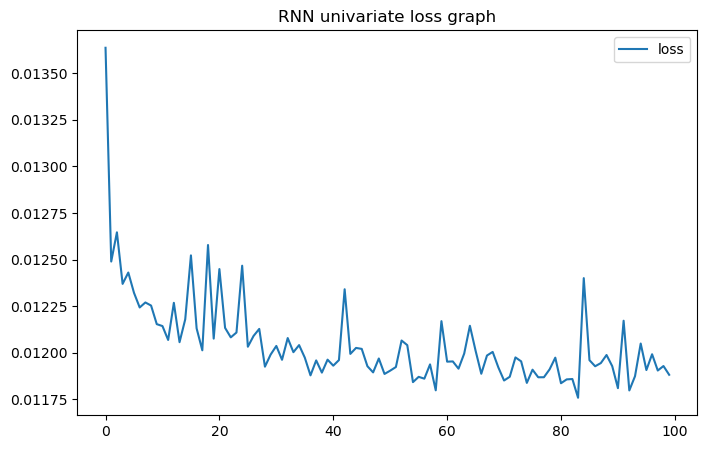

In [16]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title('RNN univariate loss graph')
plt.show()

In [17]:
sctsx = MinMaxScaler(feature_range=(0,1))
sctsx.fit(X_test.reshape(-1,1))
X_tests = sctsx.transform(X_test.reshape(-1,1))

In [18]:
sctsy = MinMaxScaler(feature_range=(0,1))
sctsy.fit(y_test.reshape(-1,1))

MinMaxScaler()

In [19]:
# version check for reshape
if versioncheck:
    X_tests =X_tests[:,:,newaxis]
else:
    pass

In [20]:
fhats = model.predict(X_tests)

In [21]:
hat_inv = sctsy.inverse_transform(fhats)

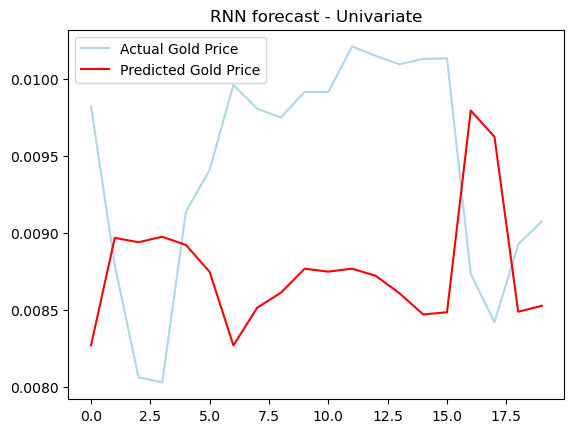

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(y_test, color='lightblue', label='Actual Gold Price')
plt.plot(hat_inv, color='red',label='Predicted Gold Price')
plt.title('RNN forecast - Univariate')
plt.legend()
plt.show()
plt.clf()

In [23]:
# metrics
mae_uv = mean_absolute_error(y_test, hat_inv)
mape_uv = mean_absolute_percentage_error(y_test, hat_inv)
mse_uv = mean_squared_error(y_test, hat_inv)
rmse_uv = np.sqrt(mse_uv)

In [24]:
print(f'MAE: {mae_uv}\nMAPE: {mape_uv}\nMSE: {mse_uv}\nRMSE: {rmse_uv}')

MAE: 0.001091246803353625
MAPE: 0.11421608425749477
MSE: 1.403680961503233e-06
RMSE: 0.0011847704256535243


In [25]:
res_dict = {'model':[], 'type':[], 'MAE':[], 'MAPE':[], 'MSE':[], 'RMSE':[]}

res_dict['model'].append('RNN')
res_dict['type'].append('univariate')
res_dict['MAE'].append(mae_uv)
res_dict['MAPE'].append(mape_uv)
res_dict['MSE'].append(mse_uv)
res_dict['RMSE'].append(rmse_uv)

In [26]:
pd.DataFrame(res_dict)

,model,type,MAE,MAPE,MSE,RMSE
0,RNN,univariate,0.001091,0.114216,0.000001,0.001185
